Run this if you have google drive mounted.

In [ ]:
"""
Documentation: https://www.gymlibrary.dev/environments/atari/pong/
"""
### Mounting a shared Google drive folder
from google.colab import drive
import os, shutil, sys

shared_drive_path = "/content/drive/"
os.makedirs(shared_drive_path, exist_ok=True) # shutil.rmtree("drive")
drive.mount(shared_drive_path, force_remount=True) # drive.flush_and_unmount()

# Installations:
!pip install -r drive/MyDrive/DQN/requirements.txt -q

# Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch, random
import torch.nn as nn
import torch.nn.functional as F

directory = "drive/MyDrive/DQN" # This is a shared directory to store all the files

# moving the files from the directory to the root directory
sys.path.append(os.path.join("/content", directory))
# for path in sys.path: print(path)
from dqn import ReplayMemory
#import config # CartPole
#from utils import preprocess
from tqdm.notebook import tqdm
from IPython.display import clear_output
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Check if multiple GPUs are available
if torch.cuda.device_count() >= 1:
    n_gpus = torch.cuda.device_count()
    print("Using", n_gpus, "GPUs")
    device = "cuda"
else:
    n_gpus = 0
    print("Using CPU")
    device = "cpu"

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

print("Ready to go!")

Mounted at /content/drive/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 11.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.9 MB/s eta 0:00:00
Using CPU
Ready to go!


This can be executed without Google Drive!

In [ ]:
# Imports
!pip install 'gymnasium[accept-rom-license]' 'gymnasium[atari]' -q
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch, random
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Check if multiple GPUs are available
if torch.cuda.device_count() >= 1:
    n_gpus = torch.cuda.device_count()
    print("Using", n_gpus, "GPUs")
    device = "cuda"
else:
    n_gpus = 0
    print("Using CPU")
    device = "cpu"

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

print("Ready to go!")

Using CPU
Ready to go!


## Training and evaluation

In [ ]:
# Hyperparameter configurations for different environments. See config.py.
ENV_CONFIGS = {
    'CartPole-v1': {
    'memory_size': 50000,
    'n_episodes': 1000,
    'batch_size': 32,
    'target_update_frequency': 100,
    'train_frequency': 1,
    'gamma': 0.95,
    'lr': 1e-4,
    'eps_start': 1.0,
    'eps_end': 0.10,
    'anneal_length': 10**2, # decreased by 100x, assuming exponential decreasing epsilon
    'n_actions': 2,
    'n_layers': 1, # changed from 0 to 1, added layer norm and residual layers
}#config.CartPole
}

class Args:
    env = 'CartPole-v1'
    evaluate_freq = 25
    evaluation_episodes = 5
    path = None #"/content/drive/MyDrive/DQN/models/CartPole-v1_best.pt"
    n_eval_episodes = 10
    render = True
    save_video = True


class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def __len__(self):
        return len(self.memory)

    def push(self, obs, action, next_obs, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.position] = (obs, action, next_obs, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """
        Samples batch_size transitions from the replay memory and returns a tuple
            (obs, action, next_obs, reward)
        """
        sample = random.sample(self.memory, batch_size)
        return tuple(zip(*sample))

def preprocess(obs, env):
    """Performs necessary observation preprocessing."""
    if env in ['CartPole-v1']:
        return torch.tensor(obs, device=device).float()
    else:
        raise ValueError('Please add necessary observation preprocessing instructions to preprocess() in utils.py.')

### successfully running
def evaluate_policy(dqn, env, env_config, args, n_episodes, render=False, verbose=False):
    """Runs {n_episodes} episodes to evaluate current policy."""
    total_return = 0
    for i in range(n_episodes):
        obs, info = env.reset()
        obs = preprocess(obs, env=args.env).unsqueeze(0)

        terminated = False
        episode_return = 0

        while not terminated:
            if render:
                env.render()

            dqn.eval()
            action = dqn.act(obs, exploit=True)
            obs, reward, terminated, truncated, info = env.step(action)
            obs = preprocess(obs, env=args.env).unsqueeze(0)
            episode_return += reward

        total_return += episode_return

        if verbose:
            print(f'Finished episode {i+1} with a total return of {episode_return}')


    return total_return / n_episodes

class DQN(nn.Module):
    def __init__(self, env_config):
        super(DQN, self).__init__()

        # Save hyperparameters needed in the DQN class.
        self.batch_size = env_config["batch_size"]
        self.gamma = env_config["gamma"]
        self.eps_start = env_config["eps_start"]
        self.eps_end = env_config["eps_end"]
        self.anneal_length = env_config["anneal_length"]
        self.n_actions = env_config["n_actions"]
        self.n_layers = env_config["n_layers"]
        self.steps_done = 0

        self.fc1 = nn.Linear(4, 256)
        ############### Newly added ###############
        self.norm = nn.LayerNorm(256)
        self.res_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(256, 256),
                nn.LayerNorm(256),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.LayerNorm(256)
            ) for _ in range(self.n_layers)
        ])
        ############################################
        self.fc2 = nn.Linear(256, self.n_actions)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.norm(x)
        x = self.relu(x)
        for block in self.res_blocks:
            identity = x
            out = block(x)
            x = self.relu(out + identity)  # Apply ReLU after adding the residual connection
        x = self.fc2(x)
        return x

    def epsilon_decay(self):
        self.epsilon = self.eps_end + (self.eps_start - self.eps_end) * np.exp(-self.steps_done / self.anneal_length)
        self.steps_done += 1

    def act(self, observation, exploit=False):
        if not exploit:
            self.epsilon_decay()
        else:
            self.epsilon = 0 # determnistic policy when exploit=True

        if random.random() > self.epsilon:
            with torch.no_grad():
                q_values = self(observation)
                action = q_values.argmax().item()
        else:
            action = random.randint(0, 1)

        return action

def optimize(dqn, target_dqn, memory, optimizer):
    if len(memory) < dqn.batch_size:
        return

    # Sample a batch from the replay memory
    obs, actions, next_obs, rewards = memory.sample(dqn.batch_size)
    obs, next_obs = torch.cat(obs, 0), torch.cat(next_obs, 0)
    actions = torch.tensor(actions).view(-1, 1).to(device)
    rewards = torch.tensor(rewards).view(-1, 1).to(device)

    # Compute the current estimates of the Q-values for each state-action pair (s,a)
    dqn.train()
    q_values = dqn(obs) # (batch_size, n_actions)
    q_values = q_values.gather(1, actions) # (batch_size, n_actions) -> (batch_size, 1)
    with torch.no_grad():
        q_targets_next = target_dqn(next_obs).max(1)[0].view(-1, 1) # Get max Q-value for the next state, then reshaping to (batch_size, 1)
        q_targets = rewards + dqn.gamma * q_targets_next

    loss = F.smooth_l1_loss(q_values, q_targets) # more robust to outliers than mse
    # loss = F.mse_loss(q_values, q_targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

args = Args()
env = gym.make(args.env)
env_config = ENV_CONFIGS[args.env]
torch.manual_seed(42)

dqn = DQN(env_config=env_config).to(device)
target_dqn = DQN(env_config=env_config).to(device)
memory = ReplayMemory(env_config['memory_size'])
optimizer = torch.optim.Adam(dqn.parameters(), lr=env_config['lr'])
loss_history = []
return_history = []
best_mean_return = -float("Inf") # Keep track of best evaluation mean return achieved so far.

for episode in tqdm(range(env_config['n_episodes'])):
    terminated = False
    obs, info = env.reset()
    obs = preprocess(obs, env=args.env).unsqueeze(0)
    num_training_steps = 0
    while not terminated:
        action = dqn.act(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        obs = preprocess(obs, env=args.env)
        next_obs = preprocess(next_obs, env=args.env).unsqueeze(0)
        memory.push(obs, action, next_obs, reward)

        if (num_training_steps % env_config["train_frequency"]) == 0:
            loss = optimize(dqn, target_dqn, memory, optimizer)
            loss_history.append(loss)

        if (num_training_steps % env_config["target_update_frequency"]) == 0:
            target_dqn.load_state_dict(dqn.state_dict())

        num_training_steps += 1
        obs = next_obs

    # Evaluate the current agent.
    if (episode % args.evaluate_freq) == 0:
        mean_return = evaluate_policy(dqn, env, env_config, args, n_episodes=args.evaluation_episodes)
        return_history.append(mean_return)
        print(f'Episode {episode+1}/{env_config["n_episodes"]}: {mean_return}')

        # Save current agent if it has the best performance so far.
        if mean_return >= best_mean_return:
            best_mean_return = mean_return

            print('Best performance so far! Saving model.')
            #torch.save(dqn, f'{directory}/models/{args.env}_best.pt')
            target_dqn.load_state_dict(dqn.state_dict()) # let the target model be the one that achieves best reward

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-e860fc6eee34>:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(obs, device=device).float()


Episode 1/1000: 76.4
Best performance so far! Saving model.
Episode 26/1000: 8.6
Episode 51/1000: 9.8
Episode 76/1000: 15.8
Episode 101/1000: 55.0
Episode 126/1000: 15.8
Episode 151/1000: 109.8
Best performance so far! Saving model.
Episode 176/1000: 66.2
Episode 201/1000: 65.6
Episode 226/1000: 32.6
Episode 251/1000: 19.0
Episode 276/1000: 10.0
Episode 301/1000: 162.8
Best performance so far! Saving model.
Episode 326/1000: 128.8
Episode 351/1000: 10.6
Episode 376/1000: 70.2
Episode 401/1000: 37.6
Episode 426/1000: 64.4
Episode 451/1000: 10.4
Episode 476/1000: 51.0
Episode 501/1000: 57.4
Episode 526/1000: 14.0
Episode 551/1000: 10.2
Episode 576/1000: 14.4
Episode 601/1000: 50.8
Episode 626/1000: 22.0
Episode 651/1000: 56.8
Episode 676/1000: 30.0
Episode 701/1000: 8.8
Episode 726/1000: 13.4
Episode 751/1000: 49.2
Episode 776/1000: 21.4
Episode 801/1000: 11.8
Episode 826/1000: 11.0
Episode 851/1000: 9.6
Episode 876/1000: 82.2
Episode 901/1000: 11.6
Episode 926/1000: 10.6
Episode 951/100

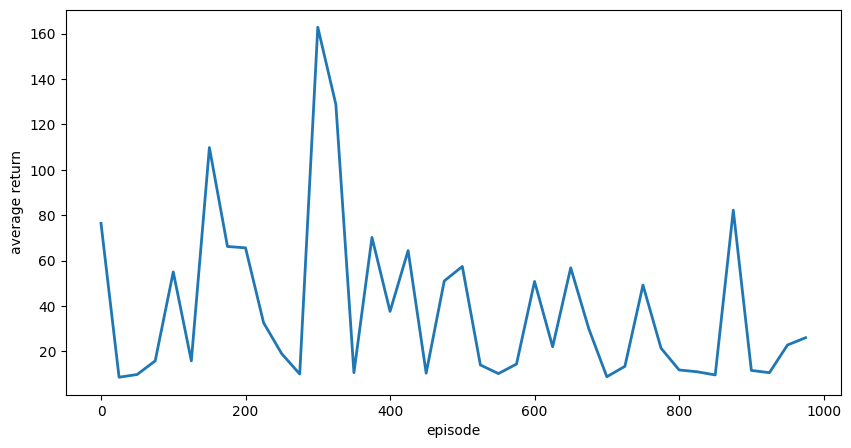

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(range(0, env_config['n_episodes'], 25), return_history)
#plt.xticks()
plt.xlabel("episode")
plt.ylabel("average return")
plt.savefig("return_per_episode_cartpole.png", bbox_inches="tight")

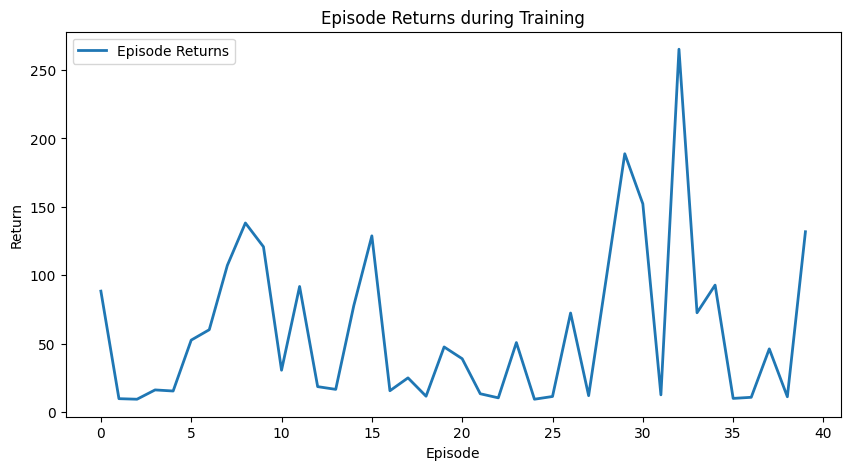

In [ ]:
import matplotlib.pyplot as plt

# 绘制回报历史
plt.plot(return_history, label='Episode Returns')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Episode Returns during Training')
plt.legend()

# 保存图表为图片文件
plt.savefig('episode_returns_plot.png')

# 显示图表
plt.show()


Plotting the loss curves and the average returns

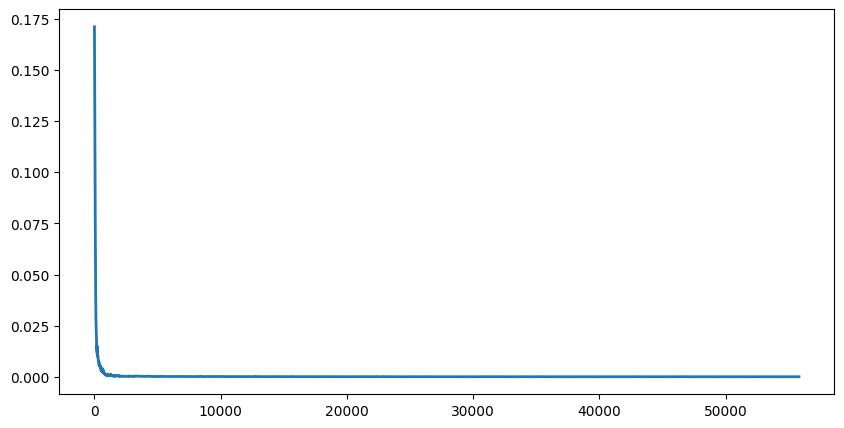

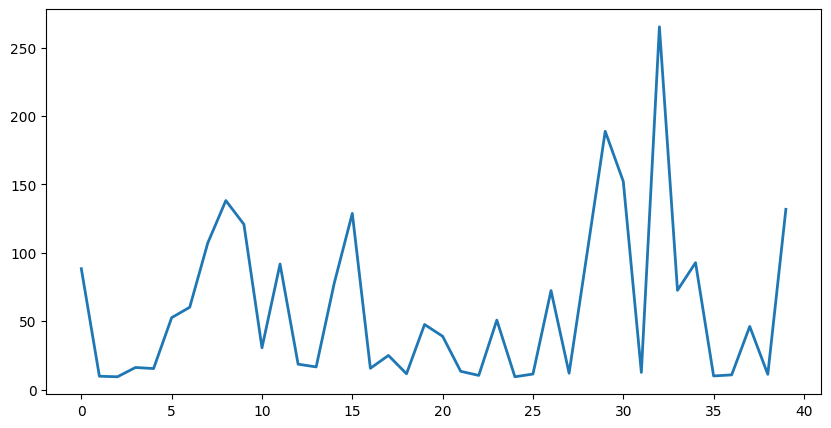

In [ ]:
def moving_average(loss_values, window_size=100):
    weights = np.ones(window_size) / window_size
    return np.convolve(loss_values, weights, mode='valid')

loss = loss_history[env_config["batch_size"]:]
smoothed_loss = moving_average(loss)

plt.plot(smoothed_loss[500:])
plt.show()
plt.plot(return_history)

In [ ]:
# Initialize environment and config
env = gym.make(args.env)
env_config = ENV_CONFIGS[args.env]

if args.save_video:
    env = gym.make(args.env, render_mode='rgb_array')
    env = gym.wrappers.RecordVideo(env, './video/', episode_trigger=lambda episode_id: True)

# Load model from provided path.
dqn = torch.load(args.path, map_location=device)
dqn.eval()

mean_return = evaluate_policy(dqn, env, env_config, args, args.n_eval_episodes, render=args.render and not args.save_video, verbose=True)
print(f'The policy got a mean return of {mean_return} over {args.n_eval_episodes} episodes.')

env.close()

AttributeError: 'NoneType' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

# Pong

1. Perform preprocessing

2. Stacking observations

3. Define policy network architecture

4. Use predefined hyperparameters:

Observation stack size: 4
Replay memory capacity: 10000
Batch size: 32
Target update frequency: 1000
Training frequency: 4
Discount factor: 0.99
Learning rate: 1e-4
Initial epsilon: 1.0
Final epsilon: 0.01
Anneal length: 10**6

5. Remove some useless actions.

6. Train.

7. Evaluate and plot.

In [ ]:
class DQNPong(nn.Module):
    def __init__(self, env_config):
        super().__init__()

        # Save hyperparameters needed in the DQN class.
        self.batch_size = env_config["batch_size"]
        self.gamma = env_config["gamma"]
        self.eps_start = env_config["eps_start"]
        self.eps_end = env_config["eps_end"]
        self.anneal_length = env_config["anneal_length"]
        self.n_actions = env_config["n_actions"]
        self.steps_done = 0

        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, self.n_actions)
        self.flatten = nn.Flatten()
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

    def epsilon_decay(self):
        # linear anneal
        self.epsilon = self.eps_start - (self.eps_start - self.eps_end) * (self.steps_done / self.anneal_length)
        self.steps_done += 1

    def act(self, observation, exploit=False):
        if not exploit:
            self.epsilon_decay()
        else:
            self.epsilon = 0 # determnistic policy when exploit=True

        if random.random() > self.epsilon:
            with torch.no_grad():
                q_values = self(observation)
                action = q_values.argmax().item()
        else:
            action = random.randint(0, self.n_actions - 1) # choose the useful actions

        return action

@torch.no_grad()
def evaluate_policy(dqn, env, env_config, args, n_episodes, render=False, verbose=False):
    """Runs {n_episodes} episodes to evaluate current policy."""
    total_return = 0
    for i in range(n_episodes):
        obs, info = env.reset()
        obs = preprocess(obs, env=args.env)[None, None]
        obs_stack = torch.cat(n_frames * [obs], 1).to(device)

        terminated = False
        episode_return = 0

        while not terminated:
            if render:
                env.render()

            dqn.eval()
            action = dqn.act(obs_stack, exploit=True)
            # Collapsing unused actions
            action = useful_action(action)
            obs, reward, terminated, truncated, info = env.step(action)
            obs = preprocess(obs, env=args.env)[None, None]
            obs_stack = torch.cat(n_frames * [obs], 1).to(device)

            episode_return += reward

        total_return += episode_return

        if verbose:
            print(f'Finished episode {i+1} with a total return of {episode_return}')

    return total_return / n_episodes

# Hyperparameter configurations for different environments. See config.py.
ENV_CONFIGS = {
    'ALE/Pong-v5': {
        'observation_stack_size': 4,
        'n_episodes': 1000,
        'memory_size': 10**4,
        'batch_size': 32,
        'target_update_frequency': 1000,
        'train_frequency': 4,
        'gamma': 0.99,
        'lr': 1e-4,
        'eps_start': 1.0,
        'eps_end': 0.01,
        'anneal_length': 10**6,
        'n_actions': 6,
    }
}

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def __len__(self):
        return len(self.memory)

    def push(self, obs, action, next_obs, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.position] = (obs, action, next_obs, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """
        Samples batch_size transitions from the replay memory and returns a tuple
            (obs, action, next_obs, reward)
        """
        sample = random.sample(self.memory, batch_size)
        return tuple(zip(*sample))

def preprocess(obs, env):
    """Performs necessary observation preprocessing."""
    if env in ['ALE/Pong-v5']:
        return torch.tensor(obs, device=device).float()

class Args:
    env = 'ALE/Pong-v5'
    evaluate_freq = 25
    evaluation_episodes = 1
    path = "/content/drive/MyDrive/DQN/models/Pong-v5_best.pt"
    n_eval_episodes = 10
    render = True
    save_video = True

def optimize(dqn, target_dqn, memory, optimizer):
    if len(memory) < dqn.batch_size:
        return

    # Sample a batch from the replay memory
    obs, actions, next_obs, rewards = memory.sample(dqn.batch_size)
    obs_stack, next_obs_stack = torch.cat(obs, 0), torch.cat(next_obs, 0)
    actions = torch.tensor(actions).view(-1, 1).to(device)
    rewards = torch.tensor(rewards).view(-1, 1).to(device)

    # Compute the current estimates of the Q-values for each state-action pair (s,a)
    dqn.train()
    q_values = dqn(obs_stack) # (batch_size, n_actions)
    q_values = q_values.gather(1, actions) # check the index for gather
    with torch.no_grad():
        q_targets_next = target_dqn(next_obs_stack).max(1)[0].view(-1, 1) # Get max Q-value for the next state, then reshaping to (batch_size, 1)
        q_targets = rewards + dqn.gamma * q_targets_next

    loss = F.smooth_l1_loss(q_values, q_targets) # more robust to outliers than mse
    # loss = F.mse_loss(q_values, q_targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

args = Args()
env = gym.make(args.env)
env_config = ENV_CONFIGS[args.env]
env = AtariPreprocessing(env, screen_size=84, grayscale_obs=True, frame_skip=1, noop_max=30)
obs, info = env.reset()

dqn = DQNPong(env_config=env_config).to(device)
target_dqn = DQNPong(env_config=env_config).to(device)
memory = ReplayMemory(env_config['memory_size'])
optimizer = torch.optim.Adam(dqn.parameters(), lr=env_config['lr'])
loss_history = []
return_history = []
best_mean_return = -float("Inf") # Keep track of best evaluation mean return achieved so far.
n_frames = env_config["observation_stack_size"]
batch_size = env_config["batch_size"]

def useful_action(action):
    if action <= 1:
        return 2
    elif action >= 4:
        return 3
    else:
        return action

for episode in tqdm(range(env_config['n_episodes'])):
    terminated = False
    obs, info = env.reset()
    obs = preprocess(obs, env=args.env)[None, None]
    obs_stack = torch.cat(n_frames * [obs], 1).to(device)

    num_training_steps = 0
    while not terminated:
        action = dqn.act(obs_stack)
        # Collapsing some actions that are not useful
        action = useful_action(action)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Think about obs_stack[:, 1:, ...], obs, is the frame stacking really correctly performed?
        next_obs = torch.from_numpy(next_obs)[None, None]
        next_obs_stack = torch.cat((obs_stack[:, 1:, ...], next_obs), dim=1).to(device)
        memory.push(obs_stack, action, next_obs_stack, reward)

        if (num_training_steps % env_config["train_frequency"]) == 0:
            loss = optimize(dqn, target_dqn, memory, optimizer)
            loss_history.append(loss)

        if (num_training_steps % env_config["target_update_frequency"]) == 0:
            target_dqn.load_state_dict(dqn.state_dict())

        num_training_steps += 1
        obs_stack = next_obs_stack

    # Evaluate the current agent.
    if (episode % args.evaluate_freq) == 0:
        mean_return = evaluate_policy(dqn, env, env_config, args, n_episodes=args.evaluation_episodes)
        return_history.append(mean_return)
        print(f'Episode {episode+1}/{env_config["n_episodes"]}: {mean_return}, {loss:.2f}, {dqn.epsilon}')

        # Save current agent if it has the best performance so far.
        #if mean_return >= best_mean_return:
            #best_mean_return = mean_return

            #print('Best performance so far! Saving model.')
            #torch.save(dqn, f'{directory}/models/{args.env}_best.pt')
            #target_dqn.load_state_dict(dqn.state_dict()) # let the target model be the one that achieves best reward

env.close()

In [ ]:
#plt.plot(loss_history[100:])
plt.plot(return_history)

In [ ]:
device = "cpu"
# Sample a batch from the replay memory
obs, actions, next_obs, rewards = memory.sample(dqn.batch_size)
obs_stack, next_obs_stack = torch.cat(obs, 0), torch.cat(next_obs, 0)
actions = torch.tensor(actions).view(-1, 1).to(device)
rewards = torch.tensor(rewards).view(-1, 1).to(device)
#print(actions.shape, rewards.shape)

# Compute the current estimates of the Q-values for each state-action pair (s,a)
dqn.train()
q_values = dqn(obs_stack) # (batch_size, n_actions)
print(actions.shape, q_values.shape)
q_values = q_values.gather(1, actions - env_config["n_actions"]) # check the index for gather
with torch.no_grad():
    q_targets_next = target_dqn(next_obs_stack).max(1)[0].view(-1, 1) # Get max Q-value for the next state, then reshaping to (batch_size, 1)
    q_targets = rewards + dqn.gamma * q_targets_next

In [ ]:

#q_values.gather(1, torch.tensor(actions))
#dqn(obs_stack).gather(1, torch.tensor(actions).T)
torch.tensor(actions).T

In [ ]:
dqn(obs_stack).shape